# Natural Language Processing for the Fake News Challenge

## Main Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Set up the data for preprocessing
### Load and sample the data

In [5]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [6]:
body_data.sample(10)

,Body ID,articleBody
672,1012,Rep. Duncan Hunter (R-CA) told Greta Van Suste...
1180,1786,A British man who went to fight against Islami...
995,1492,Robert Plant’s publicist has described as “rub...
288,456,Editors' note: There are images in this post t...
572,854,Momentum for the Apple Watch will likely take ...
425,643,"When Apple unveiled the Apple Watch, the unvei..."
720,1079,Authorities say Bary has a similar accent to t...
646,978,"According to a news source from Taiwan, the ma..."
1567,2351,Sugarhill Gang's Henry 'Big Bank Hank' Jackson...
376,572,As a feel-good video of a generous homeless ma...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [7]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 40000
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
14627,874,Following the deadly shootings at Charlie Hebd...,"Gill Rosenberg, Canadian-Israeli Woman Feared ...",unrelated,unrelated
19056,1127,Canisters packed with poisonous varieties of s...,ISIS Blasts 'Scorpion Bombs' At Civilian Areas...,agree,related
39715,2096,Islamic State militants have released a graphi...,Former Porn Star Behind YouTube Sensation ‘DC ...,unrelated,unrelated
4584,266,"In a bizarre twist during the filming of ""Batm...","Batmobile stolen in Detroit? Good one, joker!",discuss,related
14065,837,"On Friday, Nigerian armed forces chief Air Chi...",The baby from Teletubbies reveals herself,unrelated,unrelated
2501,134,"WASHINGTON, Oct. 9 (UPI) -- Homeland Security ...",Jeh Johnson shoots down Duncan Hunter's assert...,agree,related
21517,1263,BAGHDAD—An Iraqi official on Wednesday denied ...,"L. Jinny? Abdel-Majed Abdel Bary, UK Rapper, S...",unrelated,unrelated
31009,1726,"We’ve all had jobs we absolutely can’t stand, ...",That powerful Lego letter to parents from the ...,unrelated,unrelated
29831,1661,Nicaragua's government said that a mysterious ...,"L. Jinny? Abdel-Majed Abdel Bary, UK Rapper, S...",unrelated,unrelated
43876,2277,Apple took the leap into the wearable space wi...,Rumor: Gold Apple Watch Edition priced up to $...,discuss,related


### Splitting the dataset into train and validation sets

In [8]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (7977, 2)
Size of validation set: (1995, 2)


,Headline,articleBody
11952,Lawmaker Says ‘At Least 10′ Islamic State Figh...,"In North Korea, no one can have the same name ..."
4685,Doubts cast over Nicaragua meteorite claim,Islamic State militants have released a video ...
31899,ISIS Reportedly Beheads U.S. Journalist James ...,A British man who went to fight against Islami...
19798,Holy Theft! Batmobile Stolen from 'Batman v Su...,It can't be possible. I refuse to believe it. ...
13536,Amazon plans a streaming-video alternative,A previously unverified audio recording that a...
11771,"James Foley, Missing American Photojournalist,...",With Christian Bale already secured to play th...
38071,Jihadi John: Mohammed Emwazi named as masked m...,"Adding to Apple's iOS 8 launch troubles, a rep..."
175,Judd Nelson rebuffs Internet rumors that he di...,At least 25 suspected Boko Haram insurgents we...
16444,Pentagon: Airstrike killed terror leader in So...,The Pentagon confirmed today that the U.S. kil...
18696,Bali Awry,Spotting a spider on the floor may give you a ...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [9]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [10]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (7977, 22949)
Val size:  (1995, 22949)


## Evaluation Metrics

### Confusion Matrix

In [11]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [12]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [13]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7298483139024696
validation score: 0.7228070175438597


### Support Vector Machine Classifier

In [14]:
model = SVC()
model.fit(train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

     related       0.99      0.64      0.78       555
   unrelated       0.88      1.00      0.93      1440

    accuracy                           0.90      1995
   macro avg       0.93      0.82      0.86      1995
weighted avg       0.91      0.90      0.89      1995



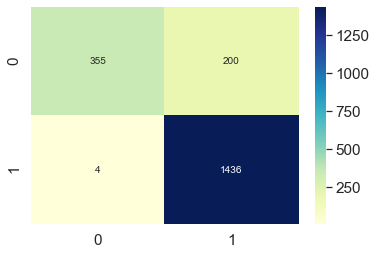

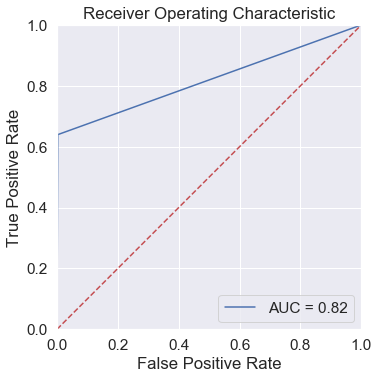

In [15]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)

In [16]:
# training an SVM on TF-IDF features
# Define the parameters to tune

parameters = {
    'C': [1, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)


              precision    recall  f1-score   support

     related       0.97      0.85      0.91       555
   unrelated       0.95      0.99      0.97      1440

    accuracy                           0.95      1995
   macro avg       0.96      0.92      0.94      1995
weighted avg       0.95      0.95      0.95      1995



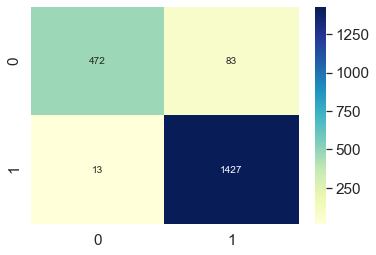

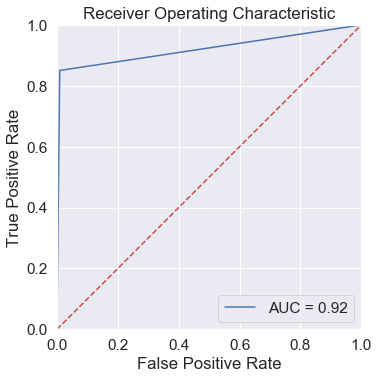

In [17]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)